<a href="https://colab.research.google.com/github/fsacconeUBA/Mossbauer/blob/main/PyMossFit_V7_ENG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
This is a Python code for fitting Mossbauer spectra obtained from source spectrometers with constant acceleration motions. (See: https://en.m.wikipedia.org/wiki/Mossbauer_spectroscopy).

#Description
In the first cell, the necessary Numpy, Scipy, Pandas, Pathlib, and Matplotlib libraries are imported. Additionally, Lmfit is installed, which will be used to perform the linear regression. While this notebook is not required to be in the same Drive directory as the data file, it is recommended, as each fitting model requires a specific notebook. The variable img is the path of the directory and must be appropriate for the location of the data file.

In [ ]:
"""
Folding by FFT and smoothing with Savizky-Golay (this last, just for poor statistics spectra). Fitting by lmfit library.
Likewise, it is included an option to identify phases by K-Nearest Neighbors (KNN) from hyperfine parameters results comparison with a local database
The next lines prepare Drive connection and import necessary libraries
"""
!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu/Iguazu01.Asc'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Parameters, minimize, fit_report, Model
from scipy.optimize import curve_fit
from scipy.constants import *
from scipy.integrate import trapezoid as trapz
from scipy.signal import savgol_filter
from scipy.stats import norm
from pathlib import Path

path= Path(img); file= path.stem; title= path.parent.name; full= path.parents[0]; print(file, title, full)

Mounted at /content/drive/
Iguazu01 Iguazu /content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu


Folding is done using the *Numpy* 'fft' library (Discrete Fourier Transform), which allows you to determine the local minimum or maximum in the central region of the Fourier spectrum, which corresponds to the folding channel, as defined by the Nyquist-Shannon theorem (https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html).

To determine the folding channel, select *idmax* or *idmin* as appropriate and adjust the neighborhood around the folding channel.

There is an optional line, commented with the # symbol, that is used to smooth spectra with a lot of statistical noise using the Savitzky-Golay algorithm. It is recommended only for calibrations since these are usually measured for shorter periods of time. In this section, the $calib.txt$ file is generated, which will store the calibration date information, the $V_{max}$ that defines the mm/s per channel, and the number of spectrometer channels. In addition, the $.csv$ file will have two columns: $V(mm/s)$ and the folded and normalized spectrum.

Enter the calibration date (YYYYMMDD): 20241202
Enter the V range (en mm/s): -15.075


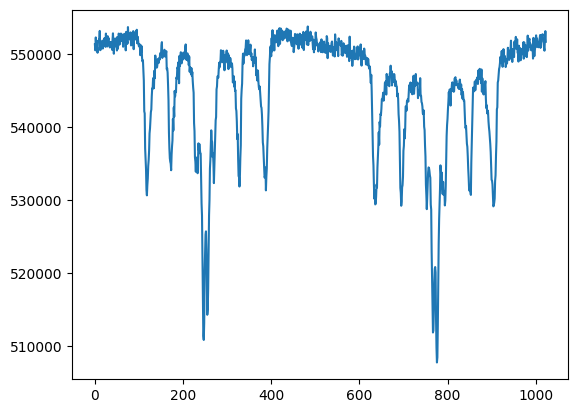

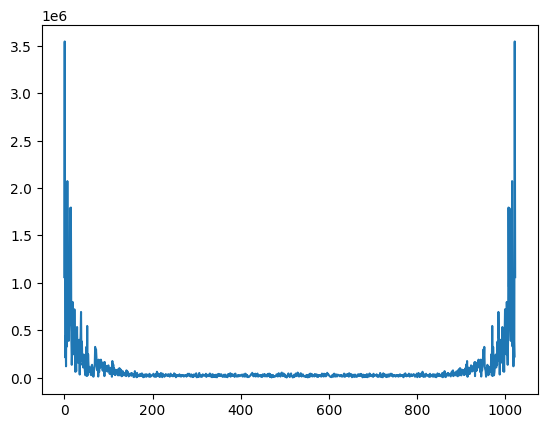

Background: 1102953
Folding Channel: 512


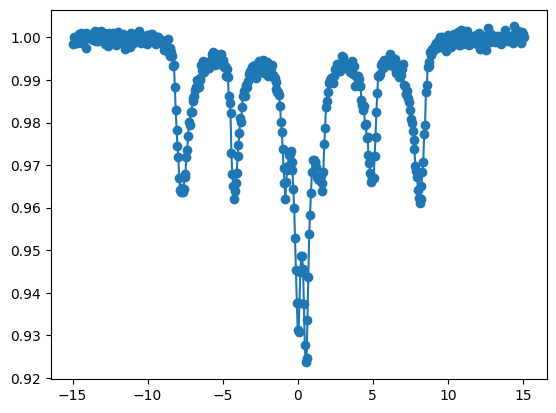

In [ ]:
"""
Loud and folding raw datafile subsection
"""
y= np.loadtxt(img, skiprows=0); #y=y[:,1] #add delivery=" " or delimiter=" " in loadtxt if it is two columns. Otherwise comment y=y[:,1]
N=len(y); N2=int(N/2); N4=int(N/4)

fecha = str(input('Enter the calibration date (YYYYMMDD): '),)
vel = float(input('Enter the V range (en mm/s): ' ), )
np.savetxt(f"{full}/{file}-calib.txt", (fecha,vel, N), fmt='%s')

#y= savgol_filter(y, 5, 2) #Only if it is a spectrum with low statistics, comment otherwise
plt.plot(y)
plt.show()

"""
Folding by FFT (based on Nyquist-Shannon sampling theorem, https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html)
"""
f= abs(np.fft.fft(y)); Nf=pd.Series(f[N2-1:N2+1]).idxmin()+(N2-1)
plt.plot(f[1:N])
plt.show()

for i in range(0, Nf-1):
    y[[i]]=y[[i]]+y[[N-1-i]]

y=y[0:N2-1]

"""
Normalisation
"""
y2= np.concatenate([y[2:30],y[N2-30:N2-2]])

ymax=np.mean(y2)
ymax=int(ymax)

for i in range(0, N2-1):
    y[[i]]=y[[i]]/ymax

x=np.arange(1,N2)

"""
From channels to mm/s
"""
v=np.loadtxt(f"{full}/{file}-calib.txt"); vmax=v[[1]]

x=np.linspace(start = 0, stop = N2-1, num= N2)

for i in range(0, N2-1):
    x[[i]]=(i-N4)*vmax/N4

x= x[0:N2-1]

print('Background:', ymax); print('Folding Channel:', Nf)

plt.plot(x,y, marker="o")
plt.show()

np.savetxt(f"{full}/{file}.csv", list(zip(x,y)), delimiter=",", fmt='%1.6f')

The following cell fits the already folded and normalized spectrum in the previous cell and reports the obtained parameters. The defined fitting functions are singlets (*singlet, S*), doublets (*doublet, Q*), and sextets (*sextet, X*) for crystalline environments of the probe nucleus and distributions for disordered environments. The latter are histograms of sextets (*dist*). These functions are subtracted from the background in Transmission and summed in CEMS measurements.

Each model requires a number of hyperfine interactions added in *y_fit*, and it is recommended to add the cardinally ordered parameters in each section.

The determination of the areas of each subspectrum is performed using the *trapz* function in *Scipy*. \
There are two output files: *plot* (multi-column with $V(mm/s)$, normalized data, subspectra, and the model total) and *report* (which contains the final hyperfine parameters of the fit for each proposed interaction). The relative percentage of each subspectra $z_{i}$ is included in the *report* output file.

How many simple Lorentzian functions do you need?1
How many Lorentzian doublets do you need?2
How many Lorentzian sextets do you need?2

--- Configurando Singlet 1 ---
Initial amplitude for Lorentzian 1: 0.46
Initial center (mm/s) for Lorentzian 1: 0.46
Initial width (mm/s) for Lorentzian 1: 0.1

--- Configurando Doublet 1 ---
Initial Delta (mm/s) for Doublet 1: 0.3
Initial Quad (mm/s) for Doublet 1: 0.6
Initial Gamma (mm/s) for Doublet1: 0.3
Initial scale for Doublet 1: 2.2

--- Configurando Doublet 2 ---
Initial Delta (mm/s) for Doublet 2: 0.5
Initial Quad (mm/s) for Doublet 2: 8.3
Initial Gamma (mm/s) for Doublet2: 0.1
Initial scale for Doublet 2: 0.05

--- Configurando Sextet 1 ---
Initial Delta (mm/s) for Sextet 1: 0.5
Initial B_hf for Sextet (mm/s) 1: 8.3
Initial Gamma (mm/s) for Sextet 1: 0.1
Initial scale for Sextet 1: 0.05

--- Configurando Sextet 2 ---
Initial Delta (mm/s) for Sextet 2: 0.2
Initial B_hf for Sextet (mm/s) 2: 9.2
Initial Gamma (mm/s) for Sextet 2: 0.1
Initial s

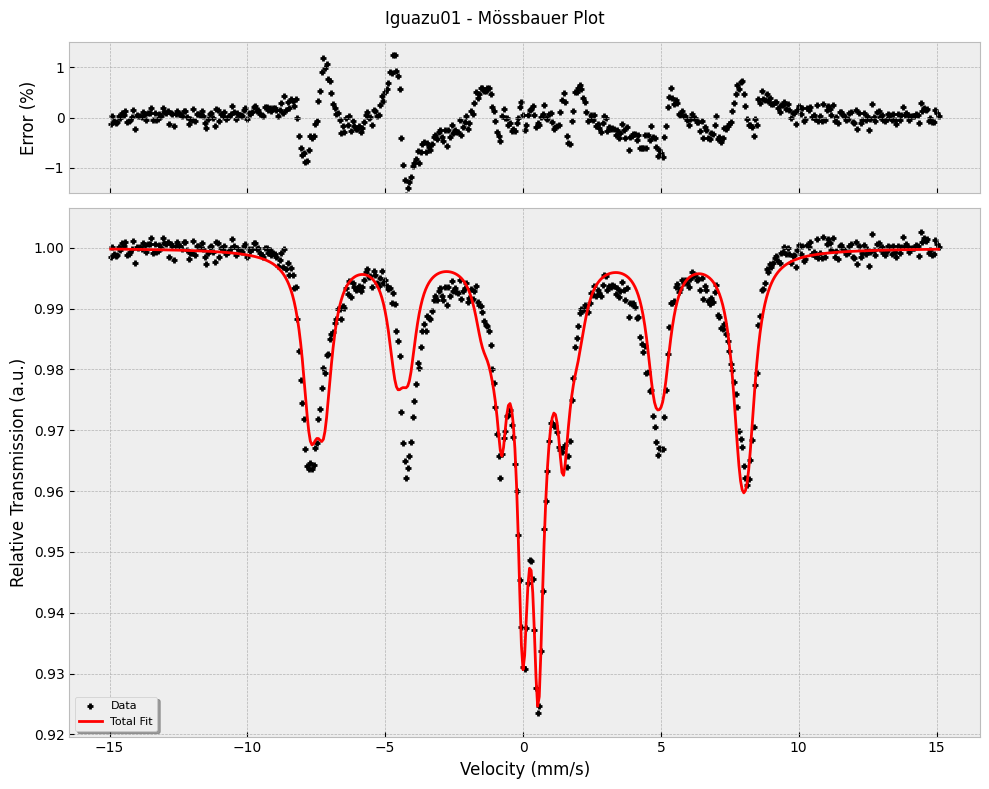

Saved data as: /content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu/Iguazu01-plot.csv
Reporte de parámetros guardado en: /content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu/Iguazu01-report.csv

SUMMARY OF THE ADJUSTMENT
    Phase       Type  Amplitude  Center (mm/s)  Width (mm/s)  IS (mm/s)  Quad Splitting (mm/s)  Bhf (T)  Area (%)  Amplitud
Lorentz 1 Lorentzian     0.0091         0.7076        0.5000        NaN                    NaN      NaN         0       NaN
Doublet 1    Doublet        NaN            NaN        0.2247     0.2716                 0.5572      NaN         0       NaN
Doublet 2    Doublet        NaN            NaN        0.2217     0.3388                 2.2169      NaN         0       NaN
 Sextet 1     Sextet        NaN            NaN        0.3500     0.4735                    NaN  47.7883         0       NaN
 Sextet 2     Sextet        NaN            NaN        0.3500     0.0814                    NaN  48.4495         0       NaN


In [ ]:
"""
Reading folded datafile
"""
col_list=[0, 1]

x, y= np.loadtxt(f"{full}/{file}.csv", delimiter=",", usecols=col_list, unpack=True)

"""
Functions definition for fitting, based in lorentzian shapes
"""
# Mössbauer constants for doublet (transition level factors)
positions_d = np.array([-1 , 1]) / 2  # Relatives to B_hf
intensities_d = np.array([1, 1])  # Relative intensity for each line


# Mössbauer constants for sextets (transition level factors)
positions_x = np.array([-1., -3/5., -1/5., 1/5, 3/5, 1.])   # Relatives to B_hf
intensities_x = np.array([3, 2, 1., 1., 2, 3])  # Relative intensity for each line
def lorentzian(x, amplitude, center, width):
    """Singlet Lorentzian Function"""
    return amplitude * (2*width / ((np.pi) * ((x - center)**2 + width**2)))

def doublet_lorentzian(x, delta, quad, gamma, scale):
    """
    Doublet model for Mössbauer spectrum of quadrupolar splitting.

    Parameters:
    - delta: Isomer Shift (IS)
    - quad: Quadrupolar Splitting (QS)
    - gamma: Lorentzian function linewidth
    - scale: intensity scale factor
    """
    y = np.zeros_like(x)
    for i, (pos, inten) in enumerate(zip(positions_d, intensities_d)):
        center = delta + pos * quad
        y += lorentzian(x, scale * inten, center, gamma)
    return y

def sextet_lorentzian(x, delta, B_hf, gamma, scale):
    """
    Sextet model for Mössbauer spectrum of Zeeman splitting.

    Parámetros:
    - delta: Isomer shift (IS)
    - B_hf: hyperfine magnetic field
    - gamma: Lorentzian function linewidth
    - scale: intensity scale factor
    """
    y = np.zeros_like(x)
    for i, (pos, inten) in enumerate(zip(positions_x, intensities_x)):
        center = delta + pos * B_hf
        y += lorentzian(x, scale * inten, center, gamma)
    return y

# Lmfit for model definition and fitting

# 1. Ask the user for the number of components
n_lorentz = int(input("How many simple Lorentzian functions do you need?"))
n_doublet = int(input("How many Lorentzian doublets do you need?"))
n_sextet = int(input("How many Lorentzian sextets do you need?"))

# 2. Create a dynamically combined model
combined_model = Model(lambda x: np.zeros_like(x))
params = Parameters()

# 3. Function to obtain initial values ​​from the user
def get_initial_values(comp_type, comp_num):
    """
    Prompts the user for initial values ​​for each parameter
    """
    print(f"\n--- Configurando {comp_type} {comp_num} ---")

    if comp_type == 'Singlet':
        amplitude = float(input(f"Initial amplitude for Lorentzian {comp_num}: ") or "0.1")
        center = float(input(f"Initial center (mm/s) for Lorentzian {comp_num}: ") or "0.0")
        width = float(input(f"Initial width (mm/s) for Lorentzian {comp_num}: ") or "0.15")
        return {'amplitude': amplitude, 'center': center, 'width': width}

    elif comp_type == 'Doublet':
        delta = float(input(f"Initial Delta (mm/s) for Doublet {comp_num}: ") or "0.3")
        quad = float(input(f"Initial Quad (mm/s) for Doublet {comp_num}: ") or "1.0")
        gamma = float(input(f"Initial Gamma (mm/s) for Doublet{comp_num}: ") or "0.15")
        scale = float(input(f"Initial scale for Doublet {comp_num}: ") or "0.2")
        return {'delta': delta, 'quad': quad, 'gamma': gamma, 'scale': scale}

    elif comp_type == 'Sextet':
        delta = float(input(f"Initial Delta (mm/s) for Sextet {comp_num}: ") or "0.5")
        B_hf = float(input(f"Initial B_hf for Sextet (mm/s) {comp_num}: ") or "2.5")
        gamma = float(input(f"Initial Gamma (mm/s) for Sextet {comp_num}: ") or "0.25")
        scale = float(input(f"Initial scale for Sextet {comp_num}: ") or "0.2")
        return {'delta': delta, 'B_hf': B_hf, 'gamma': gamma, 'scale': scale}

# 4. Adding simple Lorentzians with individual values
component_fits = {}
for i in range(n_lorentz):
    prefix = f'l{i+1}_'
    initial_vals = get_initial_values('Singlet', i+1)

    combined_model += Model(lorentzian, prefix=prefix)
    params.add_many(
        (f'{prefix}amplitude', initial_vals['amplitude'], True, 0, 1),
        (f'{prefix}center', initial_vals['center'], True, -2, 2),
        (f'{prefix}width', initial_vals['width'], True, 0.05, 0.5)
    )

# 5. Adding doublets with individual values
for i in range(n_doublet):
    prefix = f'd{i+1}_'
    initial_vals = get_initial_values('Doublet', i+1)

    combined_model += Model(doublet_lorentzian, prefix=prefix)
    params.add_many(
        (f'{prefix}delta', initial_vals['delta'], True, -0.7, 1.5),
        (f'{prefix}quad', initial_vals['quad'], True, 0, 2.5),
        (f'{prefix}gamma', initial_vals['gamma'], True, 0.0, 0.35),
        (f'{prefix}scale', initial_vals['scale'], True, 0.0, 1)
    )

# 6. Adding sextets with individual values
for i in range(n_sextet):
    prefix = f'x{i+1}_'
    initial_vals = get_initial_values('Sextet', i+1)

    combined_model += Model(sextet_lorentzian, prefix=prefix)
    params.add_many(
        (f'{prefix}delta', initial_vals['delta'], True, -0.7, 1.5),
        (f'{prefix}B_hf', initial_vals['B_hf'], True, 0, 8.5),
        (f'{prefix}gamma', initial_vals['gamma'], True, 0.0, 0.35),
        (f'{prefix}scale', initial_vals['scale'], True, 0.0, 1)
    )

# Configure initial parameters and limits

def linear_fitting_lmfit(params, x, y):
    y_fit= 1-combined_model.eval(params=params, x=x)

    return y_fit-y

# Extract results and save them in a DataFrame
param_headers = []
param_values = []
param_errors = []

# Fitting using the least squares method
result = minimize(linear_fitting_lmfit, params, args=(x,y), method='least_squares')
best_fit= 1-combined_model.eval(params=result.params, x=x)

# Calculate fits for each component individually
component_fits = {}
for i in range(n_lorentz):
    prefix = f'l{i+1}_'
    component_fits[prefix] = lorentzian(x, result.params[f'{prefix}amplitude'].value,
                                       result.params[f'{prefix}center'].value,
                                       result.params[f'{prefix}width'].value)

for i in range(n_doublet):
    prefix = f'd{i+1}_'
    component_fits[prefix] = doublet_lorentzian(x, result.params[f'{prefix}delta'].value,
                                              result.params[f'{prefix}quad'].value,
                                              result.params[f'{prefix}gamma'].value,
                                              result.params[f'{prefix}scale'].value)

for i in range(n_sextet):
    prefix = f'x{i+1}_'
    component_fits[prefix] = sextet_lorentzian(x, result.params[f'{prefix}delta'].value,
                                             result.params[f'{prefix}B_hf'].value,
                                             result.params[f'{prefix}gamma'].value,
                                             result.params[f'{prefix}scale'].value)

for name, param in result.params.items():
      param_headers.append(name)
      param_values.append(param.value)
      param_errors.append(param.stderr)

# TO CALCULATE AREAS

def calculate_areas(x, component_fits):

    """
    Correctly calculates relative areas for Mössbauer components
    """
    areas = {}
    total_absorption = 0

    # Calculate total absorption area (1 - total transmission)
    total_fit = np.zeros_like(x)
    for fit in component_fits.values():
        total_fit += fit

    total_absorption_area = trapz(total_fit, x)

    # Calculate the area of ​​each component
    for prefix, fit in component_fits.items():
        # For Mössbauer, the area is proportional to the integral of (1 - transmission_component)
        component_area = trapz(fit, x)
        areas[prefix] = (component_area/ total_absorption_area) * 100 if total_absorption_area != 0 else 0

    return areas

# Use the corrected function
component_areas = calculate_areas(x, component_fits)

# Calculate error
e= (y-best_fit)/y*100

# Print adjustment results
print(fit_report(result))

"""
SPECTRUM AND SUBSPECTRUM GRAPH
"""
# DYNAMIC GRAPH
plt.style.use('bmh')
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), height_ratios=[1,3.5])
fig.suptitle(f"{file} - Mössbauer Plot")

# Error graph
ax1.scatter(x, e, c='black', marker='+', s=20)
ax1.set_ylim(-1.5, 1.5)
ax1.set_ylabel('Error (%)')

# Principal graph
ax2.scatter(x, y, c='black', marker='+', s=20, label='Data')
ax2.plot(x, best_fit, c='red', linewidth=2, label='Total Fit')

# Colors for different components
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'black', 'gray', 'olive']

# Graph each component
color_idx = 0
for prefix, fit in component_fits.items():
    comp_type = prefix[0]  # 'l', 'd' o 'x'
    comp_num = prefix[1:]  # '1_', '2_', etc.

    if comp_type == 'l':
        label = f'Singlet {comp_num}'
    elif comp_type == 'd':
        label = f'Doublet {comp_num}'
    else:
        label = f'Sextet {comp_num}'

    ax2.plot(x, 1 - fit, c=colors[color_idx % len(colors)], label=label)
    color_idx += 1

ax2.set_xlabel('Velocity (mm/s)')
ax2.set_ylabel('Relative Transmission (a.u.)')
ax2.legend(handlelength=2, loc='lower left', shadow=True, fontsize=8)
plt.tight_layout()

plt.show()

"""
GENERATING OUTPUT FILES USING PANDAS
"""

# Create a DataFrame with the main data
plot_data = pd.DataFrame({
    'x': x,
    'y': y,
    'best_fit': best_fit
})

# Dynamically add components to the DataFrame
# Simple Lorentzians
for i in range(n_lorentz):
    prefix = f'l{i+1}_'
    fit = lorentzian(x, result.params[f'{prefix}amplitude'].value,
                    result.params[f'{prefix}center'].value,
                    result.params[f'{prefix}width'].value)
    plot_data[f'Singlet_{i+1}'] = fit

# Doublets
for i in range(n_doublet):
    prefix = f'd{i+1}_'
    fit = doublet_lorentzian(x, result.params[f'{prefix}delta'].value,
                            result.params[f'{prefix}quad'].value,
                            result.params[f'{prefix}gamma'].value,
                            result.params[f'{prefix}scale'].value)
    plot_data[f'Doublet_{i+1}'] = fit

# Sextets
for i in range(n_sextet):
    prefix = f'x{i+1}_'
    fit = sextet_lorentzian(x, result.params[f'{prefix}delta'].value,
                           result.params[f'{prefix}B_hf'].value,
                           result.params[f'{prefix}gamma'].value,
                           result.params[f'{prefix}scale'].value)
    plot_data[f'Sextet_{i+1}'] = fit

# Save DataFrame as CSV
plot_data.to_csv(f"{full}/{file}-plot.csv", index=False, float_format='%.6e')
print(f"Saved data as: {full}/{file}-plot.csv")

"""
GENERATION OF THE ENHANCED RESULTS DATAFRAME
"""

data_for_df = []

# Simple Lorentzians
for i in range(n_lorentz):
    prefix = f'l{i+1}_'
    data_for_df.append({
        'Phase': f'Lorentz {i+1}',
        'Type': 'Lorentzian',
        'Amplitude': result.params[f'{prefix}amplitude'].value,
        'Center (mm/s)': result.params[f'{prefix}center'].value,
        'Width (mm/s)': result.params[f'{prefix}width'].value,
        'IS (mm/s)': np.nan,
        'Quad Splitting (mm/s)': np.nan,
        'Bhf (T)': np.nan,
        'Area (%)': component_areas.get(prefix, 0)
    })

# Doublets
for i in range(n_doublet):
    prefix = f'd{i+1}_'
    data_for_df.append({
        'Phase': f'Doublet {i+1}',
        'Type': 'Doublet',
        'Amplitud': np.nan,
        'Center (mm/s)': np.nan,
        'Width (mm/s)': result.params[f'{prefix}gamma'].value,
        'IS (mm/s)': result.params[f'{prefix}delta'].value,
        'Quad Splitting (mm/s)': result.params[f'{prefix}quad'].value,
        'Bhf (T)': np.nan,
        'Area (%)': component_areas.get(prefix, 0)
    })

# Sextets
for i in range(n_sextet):
    prefix = f'x{i+1}_'
    Bhf =  33 / 5.312 * result.params[f'{prefix}B_hf'].value
    data_for_df.append({
        'Phase': f'Sextet {i+1}',
        'Type': 'Sextet',
        'Amplitude': np.nan,
        'Center (mm/s)': np.nan,
        'Width (mm/s)': result.params[f'{prefix}gamma'].value,
        'IS (mm/s)': result.params[f'{prefix}delta'].value,
        'Quad Splitting (mm/s)': np.nan,
        'Bhf (T)': Bhf,
        'Area (%)': component_areas.get(prefix, 0)
    })

# Create and save DataFrame
df = pd.DataFrame(data_for_df)

# Round values ​​for better presentation
numeric_columns = ['Amplitude', 'Center (mm/s)', 'Width (mm/s)', 'IS (mm/s)',
                   'Quad Splitting (mm/s)', 'Bhf (T)', 'Area (%)']
for col in numeric_columns:
    if col in df.columns:
        df[col] = df[col].round(4)

df.to_csv(f"{full}/{file}-report.csv", index=False)
print(f"Reporte de parámetros guardado en: {full}/{file}-report.csv")

# Show summary in console
print("\n" + "="*50)
print("SUMMARY OF THE ADJUSTMENT")
print("="*50)
print(df.to_string(index=False))

The following section of the code allows you to identify the phases present in the sample from the fitting results by comparing the subspectral parameters with a CSV database. There is a database of approximately 50 Fe compounds with their Mossbauer spectra for $^{57}Fe$. (This can be skipped if the phases present are known.)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Load reference data (database)
reference_path = '/content/drive/MyDrive/MyFolder/reference_data.csv'  # Assign the right folder where the "reference_data.csv" file is located
df_ref = pd.read_csv(reference_path)

# Function to convert ranges to average values ​​(e.g. "0.37-0.45" → 0.41)
def parse_value(value):
    if isinstance(value, str) and '-' in value:
        min_val, max_val = map(float, value.split('-'))
        return (min_val + max_val) / 2
    return float(value)

# Process relevant columns
cols = ['IS (mm/s)', 'Quad Splitting (mm/s)', 'Bhf (T)']
for col in cols:
    df_ref[col] = df_ref[col].apply(parse_value)

# 3. Cargar datos experimentales
experimental_path = f"{full}/{file}-report.csv"  # ¡Ajusta la ruta!
df_exp = pd.read_csv(experimental_path)

# 4. Preprocess experimental data (handle NaN)
X_exp = df_exp[cols].fillna(0).values  # Si Bhf no existe, reemplazar NaN por 0

# 5. Training KNN model
X_ref = df_ref[cols].values
model = NearestNeighbors(n_neighbors=3, metric='euclidean')
model.fit(X_ref)

# 6. Find matches
distances, indices = model.kneighbors(X_exp)

# 7. Show results
for i, (dist, idx) in enumerate(zip(distances, indices)):
    print(f"\n Experimental Phase {i+1}:")
    for j, (d, pos) in enumerate(zip(dist, idx)):
        compound = df_ref.iloc[pos]['Compound Name']
        formula = df_ref.iloc[pos]['Chemical Formula']
        is_ref = df_ref.iloc[pos]['IS (mm/s)']
        qs_ref = df_ref.iloc[pos]['Quad Splitting (mm/s)']
        bhf_ref = df_ref.iloc[pos]['Bhf (T)']
        print(f"  Match {j+1}: {compound} ({formula})")
        print(f"    IS: {is_ref:.2f} mm/s | QS: {qs_ref:.2f} mm/s | Bhf: {bhf_ref:.1f} T")
        print(f"    Euclidean Distance: {d:.2f}\n")

print("## Use this result as a guide. It is recommended to have information about the sample's composition and structure. ##")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MyFolder/reference_data.csv'